In [1]:
# https://www.youtube.com/watch?v=pEMhPBQMNjg

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [22]:
from langchain_openai import ChatOpenAI
import requests

from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

In [23]:
llm = ChatOpenAI(model="gpt-4o")

In [24]:
@tool
def get_character_info(id: int) -> dict:
    """Returns information about a specific star wars character

    Args:
        id: The ID in the StarWarsAPI for the character

        ids of characters:
        1: Luke Skywalker
        14: Han Solo

    Returns:
        dict with keys like: name, height, mass, hair_color, homeworld, starships (as a list)
        and others.
    """
    r = requests.get(f"https://swapi.info/api/people/{id}")
    return r.json()


search = DuckDuckGoSearchRun()

In [27]:
get_character_info.invoke({"id": 12})

{'name': 'Wilhuff Tarkin',
 'height': '180',
 'mass': 'unknown',
 'hair_color': 'auburn, grey',
 'skin_color': 'fair',
 'eye_color': 'blue',
 'birth_year': '64BBY',
 'gender': 'male',
 'homeworld': 'https://swapi.info/api/planets/21',
 'films': ['https://swapi.info/api/films/1', 'https://swapi.info/api/films/6'],
 'species': [],
 'vehicles': [],
 'starships': [],
 'created': '2014-12-10T16:26:56.138000Z',
 'edited': '2014-12-20T21:17:50.330000Z',
 'url': 'https://swapi.info/api/people/12'}

In [28]:
tools = [get_character_info, search]
llm_with_tools = llm.bind_tools(tools)

In [35]:
r = llm_with_tools.invoke("Tell me about Luke Skywalker")
r

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nejexqzJTsIxoEhbJ202YS5l', 'function': {'arguments': '{"id":1}', 'name': 'get_character_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 168, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5962e772-d42b-4838-bbde-6f307d9afb73-0', tool_calls=[{'name': 'get_character_info', 'args': {'id': 1}, 'id': 'call_nejexqzJTsIxoEhbJ202YS5l', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 16, 'total_tokens': 184, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [29]:
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

sys_message = SystemMessage(content="You are a useful assistant tasked with search and finding information about StarWars characters")

In [30]:
# Node
def reasoner(state: MessagesState):
    return {
        "messages": [llm_with_tools.invoke([sys_message] + state["messages"])]
    }

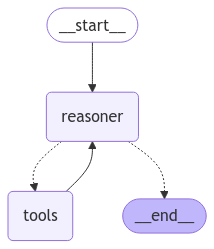

In [31]:
builder = StateGraph(MessagesState)

builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [32]:
messages = [HumanMessage(content="What is the height of Luke Skywalker and how much older is he than Han Solo?")]
messages = react_graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the height of Luke Skywalker and how much older is he than Han Solo?
================================== Ai Message ==================================
Tool Calls:
  get_character_info (call_jMj8JAsWaZAPWwzGbomTcrrI)
 Call ID: call_jMj8JAsWaZAPWwzGbomTcrrI
  Args:
    id: 1
  get_character_info (call_jK9UWGrtUGTXwytx5kAKlVc2)
 Call ID: call_jK9UWGrtUGTXwytx5kAKlVc2
  Args:
    id: 14
================================= Tool Message =================================
Name: get_character_info

{"name": "Luke Skywalker", "height": "172", "mass": "77", "hair_color": "blond", "skin_color": "fair", "eye_color": "blue", "birth_year": "19BBY", "gender": "male", "homeworld": "https://swapi.info/api/planets/1", "films": ["https://swapi.info/api/films/1", "https://swapi.info/api/films/2", "https://swapi.info/api/films/3", "https://swapi.info/api/films/6"], "species": [], "vehicles": ["https://swapi.info/api/vehic